# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from scipy.stats import ks_2samp
import statsmodels.formula.api as smf
from sklearn.metrics import roc_curve

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [4]:
#Primeiramente iremos definir a função
def biv_qual(data, var_explicativa= str, var_resposta = str):
    tab_qual = pd.crosstab(data[var_explicativa], data[var_resposta], margins= True)
    tab_qual = (tab_qual
                .assign(média_doentes = tab_qual[1].mean())
                .assign(odds = tab_qual[1]/tab_qual[0])        
    )
    tab_qual = (tab_qual
                .assign(odds_ratio = tab_qual['odds']/(tab_qual.iloc[1, tab_qual.columns.get_loc('odds')]))
                .assign(logito = np.log(tab_qual['odds']))  
    )
    tab_qual = tab_qual.assign(WOE = np.log(tab_qual['odds_ratio']))
    return tab_qual

In [5]:
#Iremos criar primeiramente a mesma bivariada do exercício passado, se a função estiver correta, a tabela deve ser identica.
tab = biv_qual(df, 'sex', 'flag_doente')
tab

flag_doente,0,1,All,média_doentes,odds,odds_ratio,logito,WOE
sex,,,,,,,,
0.0,72,25,97,92.666667,0.347222,0.280214,-1.057790,-1.272200
1.0,92,114,206,92.666667,1.239130,1.000000,0.214410,0.000000
All,164,139,303,92.666667,0.847561,0.683997,-0.165392,-0.379802


In [6]:
#Agora iremos montar bivariadas para as variaveis 'thal', 'ca' e 'restecg'
tab_thal = biv_qual(df, 'thal', 'flag_doente')
tab_thal.drop(tab_thal.index[3])#Essa linha foi usada para se retirar uma linha que estava retornando um valor inesperado.

flag_doente,0,1,All,média_doentes,odds,odds_ratio,logito,WOE
thal,,,,,,,,
3.0,129,37,166,55.6,0.286822,0.143411,-1.248894,-1.942042
6.0,6,12,18,55.6,2.000000,1.000000,0.693147,0.000000
7.0,28,89,117,55.6,3.178571,1.589286,1.156432,0.463285
All,164,139,303,55.6,0.847561,0.423780,-0.165392,-0.858540


In [7]:
tab_ca = biv_qual(df, 'ca', 'flag_doente')
tab_ca.drop(tab_ca.index[4])# De maneira semelhante ao item passado, foi dropada uma linha com valores inesperados

flag_doente,0,1,All,média_doentes,odds,odds_ratio,logito,WOE
ca,,,,,,,,
0.0,130,46,176,46.333333,0.353846,0.168881,-1.038893,-1.778560
1.0,21,44,65,46.333333,2.095238,1.000000,0.739667,0.000000
2.0,7,31,38,46.333333,4.428571,2.113636,1.488077,0.748410
3.0,3,17,20,46.333333,5.666667,2.704545,1.734601,0.994934
All,164,139,303,46.333333,0.847561,0.404518,-0.165392,-0.905060


In [8]:
tab_restecg = biv_qual(df, 'restecg', 'flag_doente')
tab_restecg

flag_doente,0,1,All,média_doentes,odds,odds_ratio,logito,WOE
restecg,,,,,,,,
0.0,95,56,151,69.5,0.589474,0.196491,-0.528525,-1.627137
1.0,1,3,4,69.5,3.000000,1.000000,1.098612,0.000000
2.0,68,80,148,69.5,1.176471,0.392157,0.162519,-0.936093
All,164,139,303,69.5,0.847561,0.282520,-0.165392,-1.264005


Se nos basearmos apenas nos valores das chances (odds), então, a variável que parece melhor discriminar o risco e a variável 'ca', pois ela possui os maiores valore de odds.

2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [9]:
def biv_quant (data, var_explicativa= str, var_resposta = str, categories = 5 ):
    #primeiramente iremos criar os labels e atribui-los corretamente
    sorted_values = data[var_explicativa].sort_values(ascending = False)
    # intervalos = pd.cut(sorted_values, bins= categories, labels= False)
    limites = pd.qcut(sorted_values, q= categories, retbins= True)[1]
    rotulos = [f"{i+1}" for i in range(categories)]
    data['labels'] = pd.cut(data[var_explicativa], bins= limites, labels= rotulos)
    
    tab_quant = pd.crosstab(data['labels'], data[var_resposta], margins= True)
    tab_quant = (tab_quant
                 .assign(média_doentes = tab_quant[1].mean())
                 .assign(odds = tab_quant[1]/tab_quant[0])
    )
    tab_quant = (tab_quant
                 .assign(odds_ratio = tab_quant['odds']/(tab_quant.iloc[3, tab_quant.columns.get_loc('odds')]))
                 .assign(logito = np.log(tab_quant['odds']))
    )
    tab_quant = tab_quant.assign(WOE = np.log(tab_quant['odds_ratio']))
    tab_quant[f'{var_explicativa} média'] = data[var_explicativa].mean()
    return tab_quant

In [10]:
tab_age = biv_quant(df, 'age', 'flag_doente', 7)
tab_age

flag_doente,0,1,All,média_doentes,odds,odds_ratio,logito,WOE,age média
labels,,,,,,,,,
1,32,11,43,34.75,0.343750,0.245536,-1.067841,-1.404313,54.438944
2,28,15,43,34.75,0.535714,0.382653,-0.624154,-0.960627,54.438944
3,38,18,56,34.75,0.473684,0.338346,-0.747214,-1.083687,54.438944
4,15,21,36,34.75,1.400000,1.000000,0.336472,0.000000,54.438944
5,15,30,45,34.75,2.000000,1.428571,0.693147,0.356675,54.438944
6,14,24,38,34.75,1.714286,1.224490,0.538997,0.202524,54.438944
7,21,20,41,34.75,0.952381,0.680272,-0.048790,-0.385262,54.438944
All,163,139,302,34.75,0.852761,0.609115,-0.159276,-0.495749,54.438944


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

**OBS:** Não é possível construir uma regressão logística como pedida acima ('age ~ sex + cp + trestbps'), pois age não é uma variável binária, por isso, será construída uma regressão com a variável 'flag_doente' e as variáveis mencionadas acima.

In [11]:
reglog = smf.logit("flag_doente ~ age + cp + trestbps + sex"
                   , data = df).fit()
reglog.summary()

Optimization terminated successfully.
         Current function value: 0.510076
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      298
Method:                           MLE   Df Model:                            4
Date:                Tue, 20 Feb 2024   Pseudo R-squ.:                  0.2605
Time:                        19:31:02   Log-Likelihood:                -154.55
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.264e-22
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.1167      1.608     -6.915      0.000     -14.267      -7.966
age            0.0582      0.017      3.348      0.001       0.024       0.092
cp             1.1403      0.169      6.739      0.000       0.809       1.472
trestbps       0.0214      0.008      2.600      0.009       0.005       0.037
sex            1.8021      0.331      5.444      0.000       1.153       2.451
==============================================================================
"""

Observando o súmario acima, vemos que todas as variáveis são relevantes quando colocadas neste modelo, porém, ainda assim, não são suficientes para se gerar uma descrição satisfatória do modelo, sendo o r-quadrado de apenas 26%.

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

In [12]:
#Calculando a probabilidade e categorizando-a em 5 grupos
df['predito'] = reglog.predict(df)
cat_pred = pd.qcut(df['predito'], 5, duplicates= 'drop')
cat_pred.value_counts().sort_index()

predito
(0.0119, 0.146]    61
(0.146, 0.349]     60
(0.349, 0.575]     61
(0.575, 0.772]     60
(0.772, 0.928]     61
Name: count, dtype: int64

In [13]:
group_reg = df.groupby(cat_pred)
qualid = group_reg[['predito']].count().rename(columns = {'predito': 'contagem'})
qualid['predito_'] = group_reg['predito'].mean()
qualid['pct_doentes'] = group_reg['flag_doente'].mean()
qualid

C:\Users\samsun\AppData\Local\Temp\ipykernel_11272\2534591397.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_reg = df.groupby(cat_pred)


,contagem,predito_,pct_doentes
predito,,,
"(0.0119, 0.146]",61,0.076255,0.098361
"(0.146, 0.349]",60,0.249060,0.183333
"(0.349, 0.575]",61,0.457982,0.491803
"(0.575, 0.772]",60,0.673059,0.683333
"(0.772, 0.928]",61,0.837449,0.836066


Text(0.5, 0, 'Grupo')

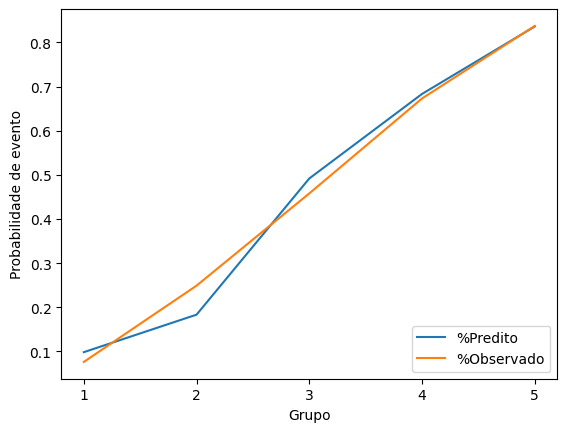

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax = qualid['pct_doentes'].plot(label='%Predito')
ax = qualid['predito_'].plot(label='%Observado')

ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])
ax.legend(loc="lower right")
ax.set_ylabel('Probabilidade de evento')
ax.set_xlabel('Grupo')

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [15]:
#Calculando a acurácia
acc = metrics.accuracy_score(df['flag_doente'], df['predito']>.5)
#Calculando o GINI
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)
gini = 2*auc_ -1
#Calculando o KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito'], df.loc[df['flag_doente'] != 1, 'predito']).statistic

print(f'Acurácia: {(acc*100):.2f}%\nGINI: {(gini*100):.2f}%\nKS: {(ks*100):.2f}%')

Acurácia: 77.89%
GINI: 66.22%
KS: 58.40%


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [17]:
#As variáveis abaixo foram tratadas para retirar as colunas onde os valores eram '?'
df = df[df['ca']!='?']
df = df[df['thal']!= '?']
reglog_2 = smf.logit("flag_doente ~  + cp + trestbps + sex + ca + thal"
                   , data = df).fit()
reglog_2.summary()

Optimization terminated successfully.
         Current function value: 0.395740
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  297
Model:                          Logit   Df Residuals:                      288
Method:                           MLE   Df Model:                            8
Date:                Tue, 20 Feb 2024   Pseudo R-squ.:                  0.4266
Time:                        19:31:46   Log-Likelihood:                -117.53
converged:                       True   LL-Null:                       -204.97
Covariance Type:            nonrobust   LLR p-value:                 1.224e-33
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -8.5809      1.641     -5.230      0.000     -11.796      -5.365
ca[T.1.0]       1.8026      0.405      4.447      0.000       1.008       2.597
ca[T.2.0]       2.8369      0.597      4.755      0.000       1.667       4.006
ca[T.3.0]       2.0615      0.714      2.887      0.004       0.662       3.461
thal[T.6.0]     1.0469      0.692      1.512      0.130      -0.310       2.403
thal[T.7.0]     1.8820      0.369      5.098      0.000       1.158       2.606
cp              0.8710      0.181      4.811      0.000       0.516       1.226
trestbps        0.0247      0.010      2.549      0.011       0.006       0.044
sex             1.0499      0.400      2.628      0.009       0.267       1.833
===============================================================================
"""

In [18]:
df['predito_2'] = reglog_2.predict(df)
acc = metrics.accuracy_score(df['flag_doente'], df['predito_2']>.5)
acc

0.8451178451178452

No modelo acima, foi retirada a variável 'age' e adicionadas as variáveis 'ca' e 'thal', com isso, o valor do r-quadrado subiu para quase 43% e a acurácia foi para 84%, um aumento significativo nos valores mencionados.